#### Geometric Brownian Motion + Ornstein Uhlenbeck Code

This Notebook is aimed to show how GBM and the OU process can be used to predict prices of stocks based on historical market data. The main reference will be the quantpie video on GBM. We aim to:

- Give an overview of the mathematics underlying the Stochastic Processes
- Explain how to collect and store the market data and use it to calibrate our model
- Display the results of the models on a few graphs

---
#### Section 1: GBM Formulae
---

## Geometric Brownian Motion (GBM) Notes

#### 1. Stochastic Differential Equation (SDE) for GBM

The SDE for a Geometric Brownian Motion is given by:

$dX_t = \mu X_t \, dt + \sigma X_t \, dB_t$

Additionally, by Ito's Lemma, we have:

$dX_t^2 = \sigma^2 X_t^2 \, dt$


#### 2. Solution for the SDE

The solution to the above differential equation is:

$X_T = X_0 e^{\left( \mu - \frac{\sigma^2}{2} \right)T + \sigma B_T}$

This shows that $X_T$ follows a **log-normal distribution**.


#### 3. Expected Value, Variance, and Covariance

**Expected Value:**

$E[X_T] = e^{\log{X_0} + \mu T} = X_0 e^{\mu T}$

**Variance:**

$V[X_T] = X_0^2 e^{2\mu T} \left( e^{\sigma^2 T} - 1 \right)$

**Covariance:**

$C[X_T, X_S] = E[X_T X_S] - E[X_T] E[X_S] = X_0^2 e^{\mu (T + S)} \left( e^{\sigma^2 \min(T, S)} - 1 \right)$


#### 4. Probability Density Function (PDF) of $X_T$

Given that $X_T$ follows a log-normal distribution, we can derive the PDF using a transformation of the normal distribution.

For a normally distributed random variable $ Z \sim N(\mu, \sigma^2) $, its PDF is:

$f_Z(z) = \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{(z - \mu)^2}{2 \sigma^2}}$

Since $ X_T = e^Z $, we can apply the transformation formula for PDFs:

$f_X(x) = f_Z(z = \log x) \left| \frac{dz}{dx} \right|$

This gives the PDF for $X_T$:

$f_X(x) = \frac{1}{x \sigma \sqrt{2\pi}} e^{-\frac{(\log x - \mu)^2}{2 \sigma^2}}$



---
#### Section 2: Using GBM to simulate market prices
---

For our historical data, we shall take market data from the S&P 500 index, arguably the most famous stock market index globally.

We can obtain free historical data in a .csv file from the Nasdaq website : https://www.nasdaq.com/market-activity/index/spx/historical?page=1&rows_per_page=10&timeline=m1

In [851]:
import pandas as pd
import numpy as np

dataframe = pd.read_csv("S&P_DailyData2.csv")
print(dataframe.head())

sp_returns = dataframe.iloc[:,1].values

#sp_returns = [7281.6, 7304, 7302.1, 7300.2, 7331.1, 7367.3, 7490.2, 7458.4, 7507.6, 7511.5, 7545.4, 7510.2, 7495.7, 7474.6, 7510.3, 7418.3, 7318.5]

         Date  Close/Last     Open     High      Low
0  10/08/2024     5751.13  5719.14  5757.60  5714.56
1  10/07/2024     5695.94  5737.80  5739.34  5686.85
2  10/04/2024     5751.07  5737.48  5753.21  5702.83
3  10/03/2024     5699.94  5698.19  5718.78  5677.37
4  10/02/2024     5709.54  5698.14  5719.63  5674.00


#### Calibrating GBM Model: Computing Statistical Estimates

With the sample dataset of daily S&P 500 figures shown above, we can obtain our figures for the model using simple statistical formulae

We first need to calculate the mean and standard deviation 

Let $X_i$ be our random variable: The percentage return of the index on day $i$

We define the distribution: $X_i \sim e^Z$ where $Z \sim N[\hat{\mu} , \hat{\sigma}^2]$

Above, we take the log of the percentage difference between daily returns, which means that our values will all be sampled from a normal distribution

$\implies Y_i = \ln(X_i) \sim N[\hat{\mu}, \hat{\sigma}^2]$

Note that we are calculating **sample** mean and variance from the dataset:

$\hat{\mu} = \frac{1}{n}\sum_{i=1}^{n}r_i$

$\hat{\sigma}^2 = \frac{1}{n-1}\sum_{i=1}(r_i-\hat{\mu})^2$

By the definition of Brownian motion (Weiner Process), we assume that the daily log returns are indepenent of each other: $X_{i+1} \perp X_i$ 

If we assume that there are 252 official working days in a calendar year (take out weekends), we can estimate the **Annual Mean and Variance**:

$\hat{\mu}_a = E\left[ \sum_{i=1}^{252} X_i\right] = 252E\left[X_i\right] = 252\hat{\mu}$

$\hat{\sigma}_a^2 = V\left[ \sum_{i=1}^{252} X_i\right]= 252E\left[X_i\right] = 252\hat{\sigma}^2$

In [852]:
sp_log_returns = [np.log((sp_returns[i+1])/(sp_returns[i])) for i in range(len(sp_returns)-1)]

mean = np.sum(sp_log_returns)*1/(len(sp_log_returns))

diff = sp_log_returns - mean
diff_squared = diff ** 2

variance = 1/(len(sp_log_returns) - 1)*np.sum(diff_squared)

mean_annual = 252 * mean
variance_annual = 252 * variance

print("Daily log returns of S&P500", sp_log_returns)
print("\n")
print("Mean of Sample Dataset: ", mean)
print("Variance of Sample Dataset: ", variance)
print("\n")
print("Annual Mean of Sample Dataset: ", mean_annual)
print("Annual Variance of Sample Dataset: ", variance_annual)

Daily log returns of S&P500 [-0.009642716894192658, 0.009632284107421302, -0.008930275984437828, 0.001682811533125682, -0.00013837448536695794, 0.009367852083837102, -0.004227593432856147, 0.0012539688882457609, -0.00403048080287232, 0.001862911586066849, -0.0025079697029957225, -0.00280533091435692, 0.001942855451501875, -0.01683429124758689, 0.002900603126385081, -0.0002644734907367131, -0.0012558720767879706, -0.005393096878371331, -0.007467372942030409, -0.010608580303038828, -0.004462660724490126, -0.011513555690021375, 0.01741090167086747, 0.0030226412501879645, 0.0016037653903594067, 0.021378012454581333, -0.010042467382856598, 3.93414245581577e-05, 0.005993966945423359, -0.0015939320118754036, 0.0031587066155746614, -0.01141798620850249, 0.008972949425464515, -0.004230718284184631, 0.001986548174716375, -0.009675327436177735, -0.0019878411263283815, -0.016004444012785883, -0.003816476067632444, -0.01670722665493316, -4.303670751152225e-05, -0.0046607802121506215, -0.02278112857

#### Calibrating GBM Model: Building the Model from Estimates

We can now proceed to calibrate our model. 

We first define the time increments

$t = 1$ will correspond to 1 year.

Consequently, we let $\Delta t = 1/252$ equal 1 day

We lastly apply our estimates to our random variable $X_T$

---
Sidenote:

$X_T = X_0 e^{\left( \mu - \frac{\sigma^2}{2} \right)T + \sigma B_T} \implies$ (Do some manipulation) $\implies \ln\frac{X_T}{X_0} = \left( \mu - \frac{\sigma^2}{2} \right)T + \sigma B_T$

We note that the manipulated formula above is Arithmetic Brownian Motion: 

$dX_t = \mu dt + \sigma dB_t \implies X_T  = X_0 \mu T + \sigma B_T \sim N\left[ X_0 + \mu T, \sigma^2 T \right]$

$\therefore \; \ln\frac{X_T}{X_0} \sim N\left[\left(\mu - \frac{\sigma^2}{2} \right)T , \sigma^2 T\right]$

We now plug in our statistical estimates:

$\sigma^2 = \hat{\sigma}^2$ 

$\hat{\mu} = \left( \mu - \frac{\hat{\sigma}^2}{2} \right) \implies \mu = \left( \hat{\mu} + \frac{\hat{\sigma}^2}{2} \right)$

These can be inputted back into our original equation: $dX_t = \mu X_t \, dt + \sigma X_t \, dB_t$

---
**EXAMPLE**: If $\hat{\mu} = 0.08$ and $\hat{\sigma}^2 = 0.013$ we would get

$\sigma^2 = \hat{\sigma}^2 = 0.013$

$\mu = \hat{\mu} + \frac{\hat{\sigma}^2}{2} = 0.08 + \frac{0.013}{2} = 0.0865$

$X_T = X_0 e^{\left( \mu - \frac{\sigma^2}{2} \right)T + \sigma B_T} \implies X_T = X_0 e^{\left( 0.08 \right)T + \sqrt{0.013} B_T}$

We now converts this formula into an incremental one:

$X_{t+\Delta t} = X_t e^{\left( 0.08 \right)\Delta t + \sqrt{0.013} \sqrt{\Delta t}N(0,1)}$

We can also get the distribution of the simluated path by using the lognormal distribution (Assume $X_0 = 7318.5$):

$X \sim LN\left[ \ln X_0 + (\mu - \sigma^2 / 2)T, \sigma^2 T \right] \implies X \sim LN\left[ \ln 7318.5 + 0.08 \frac{T}{252}, 0.013\frac{T}{252} \right]$

Since we have already defined $\Delta t = 1/252$ we are now ready to make some graphs!

---
#### Section 3: Graphing of Results
---

Graph 1: Here is a graph showing the simulation of values for the S&P 500 using the GBM model (Monte Carlo Simulation)

[array([1.64501671e-05, 1.64900934e-05, 1.65301011e-05, ...,
        2.37208388e-06, 2.36822313e-06, 2.36436831e-06]),
 array([3571.57562059, 3571.86631055, 3572.1570005 , ..., 6477.60311958,
        6477.89380954, 6478.18449949])]

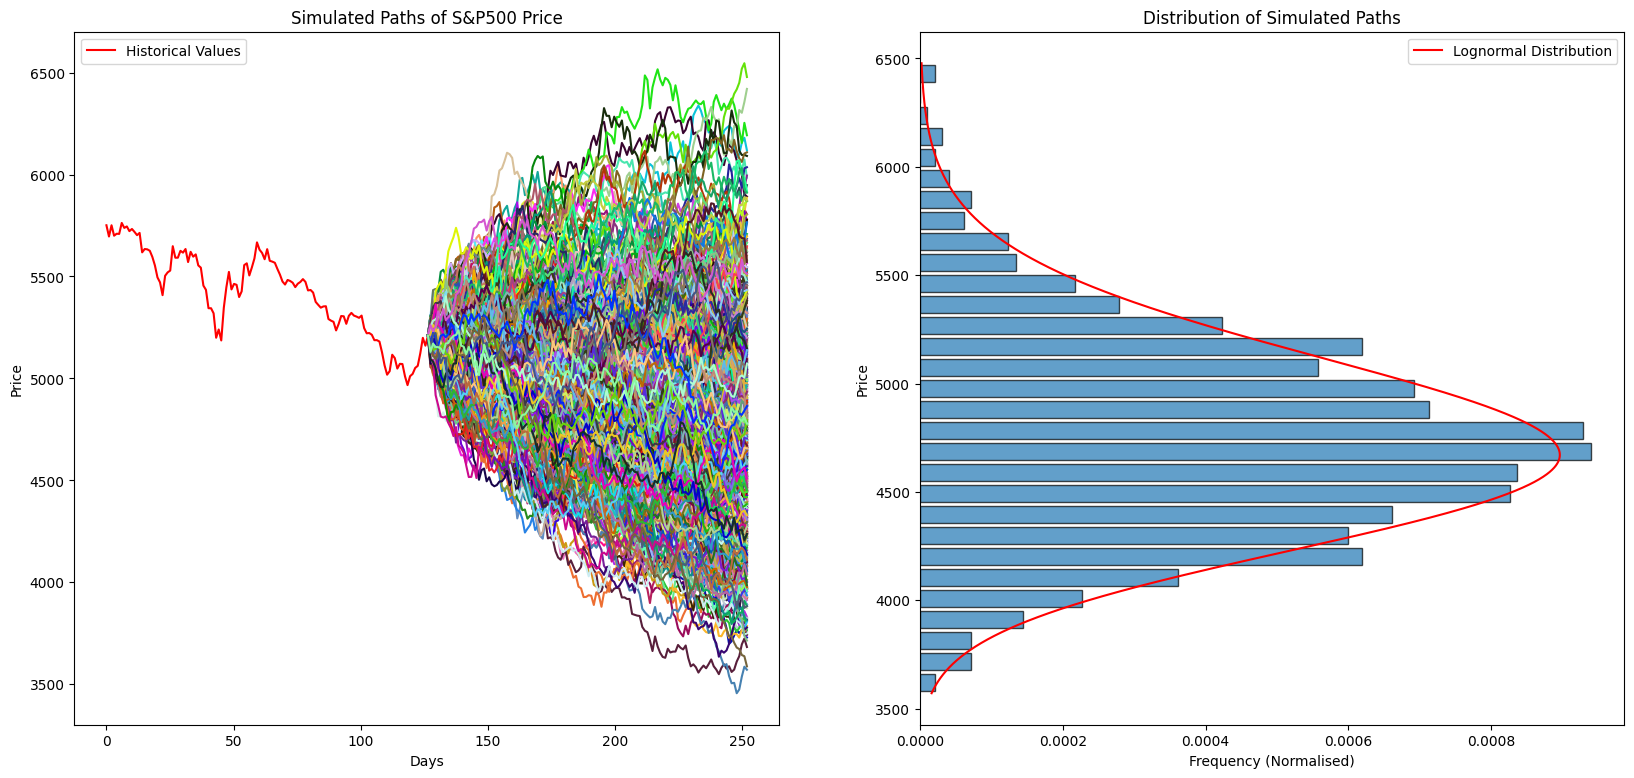

In [853]:
import matplotlib.pyplot as plt
from scipy.stats import lognorm


def run_sim(N):
    X = np.zeros(N+1)
    X[0] = X_0
    
    for i in range(N):

        # GBM Equation
        X[i+1] = X[i]*np.exp(mean_annual*dt + np.sqrt(variance_annual*dt)*np.random.standard_normal())

    return X


def plot_sim(N, M, plot3D):

    # We will plot the historical data alongside the simluated values to visualise how the historical data influences the simluation
    full_curve = np.zeros(len(sp_returns) + N+1)
    
    for i in range(len(sp_returns)):
        full_curve[i] = sp_returns[i]

    t = np.linspace(0,N,N+1)
    full_t = np.linspace(0, N + len(sp_returns)-1, N + len(sp_returns)-1)

    final_vals = []
    # We plot our results below. Our historical data is in red, while the simulated values are colored randomly

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,9))

    ax1.plot(full_t[full_t<len(sp_returns)], full_curve[:len(sp_returns)], color='r', label="Historical Values")
    for i in range(M):
        X = run_sim(N)

        for i in range(N):
            full_curve[i + len(sp_returns)] = X[i]

        final_vals.append(full_curve[-2])
        ax1.plot(full_t[full_t>=len(sp_returns)-1], full_curve[len(sp_returns):len(full_curve)-1], color=np.random.rand(3))

    ax1.set_xlabel("Days")
    ax1.set_ylabel("Price")
    ax1.legend()
    ax1.set_title("Simulated Paths of S&P500 Price")


    # Making sure density = True ensures that the area under the histogram equals 1, thus allowing you to plot a pdf line over it!
    ax2.hist(final_vals, bins=30, orientation="horizontal", edgecolor="black", alpha=0.7, rwidth=0.8, density=True)

    shape, loc, scale = lognorm.fit(final_vals, floc=0)  # Fit the lognormal distribution
    x_vals = np.linspace(min(final_vals), max(final_vals), 10000)  # Generate x values for the distribution
    
    # this function calculates the lognormal pdf given the input parameters shape, loc and scale
    pdf_vals = lognorm.pdf(x_vals, shape, loc, scale)
    
    ax2.plot(pdf_vals, x_vals, color='r', label="Lognormal Distribution")
    ax2.set_xlabel("Frequency (Normalised)")
    ax2.set_ylabel("Price")
    ax2.legend()
    ax2.set_title("Distribution of Simulated Paths")
    
    if plot3D == True:
        plt.close()

    return [pdf_vals, x_vals]

# N = Number of days
# M = Number of simulations
N = 252
M = 1000

# t is our time
t = 1
dt = 1/N

# X_0 is our initial value
X_0 = sp_returns[-1]

plot_sim(int(N/2), M, False)


# NOTE: Add in a vertical line at the end of the historical data and then make arrows from the line pointing to the past and to the future!


Graph 2: This 3D graph demonstrates how the distribution of the stock price spreads out as t increases

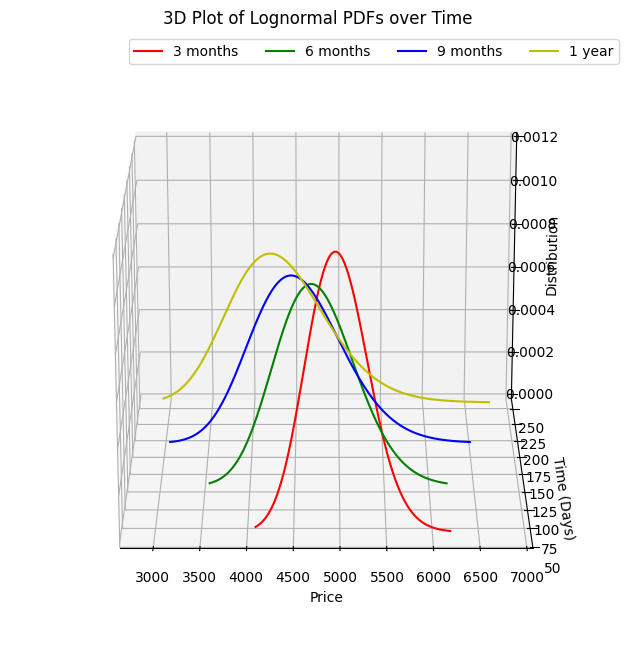

In [854]:
# Initialize 3D plot
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection="3d")

times = [N // 4, N // 2, 3 * N // 4, N]  # Time points for PDFs
written_times = ["3 months", "6 months", "9 months", "1 year"]
colors = ['r', 'g', 'b', 'y']

# Store PDF values for each time
for idx, time in enumerate(times):
    pdf_vals, x_vals = plot_sim(time, M, True)  # Get PDF and x_vals at each time step
    ax.plot(x_vals, time, zs=pdf_vals, zdir='z', color=colors[idx], label = written_times[idx])

ax.set_xlabel('Price')
ax.set_ylabel('Time (Days)')
ax.set_zlabel('Distribution')
ax.set_title('3D Plot of Lognormal PDFs over Time')
ax.view_init(elev=20., azim=-90, roll=0)
ax.legend(ncols=4)
plt.show()